### Import Lib

In [571]:
import geopandas as gpd
import pandas as pd
import numpy as np
from shapely.wkt import loads
import constant as c
from pyproj import CRS
import sys;sys.path.append('../')
from itertools import combinations
from sklearn.preprocessing import StandardScaler
import math
import matplotlib.pyplot as plt
import warnings; warnings.filterwarnings('ignore')

### Acquire Data

In [572]:
# then read the data
df_2020 = pd.read_csv('../asset/preprocess/df_2020.csv', index_col=0)
df_2020['geometry_grids'] = df_2020['geometry_grids'].apply(lambda x: loads(x))
df_2021 = pd.read_csv('../asset/preprocess/df_2021.csv', index_col=0)
df_2021['geometry_grids'] = df_2021['geometry_grids'].apply(lambda x: loads(x))
df_2022 = pd.read_csv('../asset/preprocess/df_2022.csv', index_col=0)
df_2022['geometry_grids'] = df_2022['geometry_grids'].apply(lambda x: loads(x))

crs = 'EPSG:5179'  # Specify the coordinate reference system
gdf_2020 = gpd.GeoDataFrame(df_2020, geometry=df_2020['geometry_grids'], crs=crs)
gdf_2021 = gpd.GeoDataFrame(df_2021, geometry=df_2021['geometry_grids'], crs=crs)
gdf_2022 = gpd.GeoDataFrame(df_2022, geometry=df_2022['geometry_grids'], crs=crs)

gdf_2020_scbd = gdf_2020[gdf_2020['sigungunm'].isin(c.SCBD_NMS)]
gdf_2020_gbd = gdf_2020[gdf_2020['sigungunm'].isin(c.GBD_NMS)]
gdf_2020_ybd = gdf_2020[gdf_2020['sigungunm'].isin(c.YBD_NMS)]
gdf_2021_scbd = gdf_2021[gdf_2021['sigungunm'].isin(c.SCBD_NMS)]
gdf_2021_gbd = gdf_2021[gdf_2021['sigungunm'].isin(c.GBD_NMS)]
gdf_2021_ybd = gdf_2021[gdf_2021['sigungunm'].isin(c.YBD_NMS)]
gdf_2022_scbd = gdf_2022[gdf_2022['sigungunm'].isin(c.SCBD_NMS)]
gdf_2022_gbd = gdf_2022[gdf_2022['sigungunm'].isin(c.GBD_NMS)]
gdf_2022_ybd = gdf_2022[gdf_2022['sigungunm'].isin(c.YBD_NMS)]

In [573]:
# Setting COLS
SIM_CAL_COLS = c.SIM_CAL_COLS
STANDARDIZE_COLS = c.STANDARDIZE_COLS
PP_COLS = c.PP_COLS
BS_COLS = c.BS_COLS
BD_COLS = c.BD_COLS

#### 1. Get Boundary

- Data preparation(calculating nearest grid_idx, and apply Standard Scaler)

In [574]:
# Function to find grid indexes within a radius of 300 meters
def find_neighbors_within_radius(gdf, grid_idx):
    target_geometry = gdf.loc[gdf['grid_idx'] == grid_idx, 'geometry'].centroid.values[0]
    # Calculate the distances between the target geometry and all other geometries
    distances = gdf['geometry'].centroid.distance(target_geometry)
    # Filter the grid indexes based on the specified radius
    neighbors = gdf.loc[distances <= 400, 'grid_idx'].tolist()
    neighbors = [idx for idx in neighbors if idx != grid_idx]
    return neighbors

def find_queen_neighbors(gdf, grid_idx):
    target_geometry = gdf.loc[gdf['grid_idx'] == grid_idx, 'geometry'].centroid.values[0]
    # Calculate the distances between the target geometry and all other geometries
    distances = gdf['geometry'].centroid.distance(target_geometry)
    # Filter the grid indexes based on the specified radius
    neighbors = gdf.loc[distances < 100*math.sqrt(2)+1, 'grid_idx'].tolist()
    neighbors = [idx for idx in neighbors if idx != grid_idx]
    return neighbors

def compare_mean(row1, rows, sim_cal_cols):
    """
    square the difference and sum for all columns and divide by 13 and make that root. 
    input is one row data and multiple rows data and sim_cal_cols. 
    :params row1: one row
    :params rows: multiple rows
    """
    row1_mean = np.mean(row1[sim_cal_cols])
    rows_mean = np.mean(rows[sim_cal_cols], axis=0)
    diff_squared = np.sum((row1_mean - rows_mean)**2)
    mean_diff = np.sqrt(diff_squared / len(sim_cal_cols))
    return mean_diff


def within_boundary_distance(gdf, sim_cal_cols) -> float:
    pairwise_distances = []
    for row1, row2 in combinations(gdf.iterrows(), 2):
        distance = sum(abs(row1[1][col] - row2[1][col]) for col in SIM_CAL_COLS)
        pairwise_distances.append(distance)
    average_distance = sum(pairwise_distances) / len(pairwise_distances)
    # boundary_similarity = math.exp(-(average_distance/100))
    # penalty = math.sqrt(len(gdf))
    # penalty = 1 / math.sqrt(len(pairwise_distances))
    return average_distance 

def within_boundary_similarity(dist, n_cluster) -> float:
    return math.exp(-dist/100)

#### Experiment Settings

In [575]:
# experiment settings
YEAR = 2020
CBD_NM = "ybd"

#### Execute Experiment

In [576]:
TOPK = 3 # number of grids selected for each clustering phase
PHASE_N = 9999999
# Construct the DataFrame variable name
df_nm = f'gdf_{YEAR}_{CBD_NM}'
gdf = gpd.GeoDataFrame(locals()[df_nm], geometry='geometry_grids')
MAX_GRIDS_N = int(len(gdf) * 0.1)
print(f"Total Grids: {len(gdf)}\nNum Max grids: {MAX_GRIDS_N}")

# Set the CRS for the GeoDataFrame
crs = CRS.from_epsg(5179)
gdf = gdf.set_crs(crs)
gdf = gdf.dropna() # drop any data have null value

# and normailze
# Initialize the StandardScaler object
scaler = StandardScaler()
# Fit the scaler to the data
scaler.fit(gdf[STANDARDIZE_COLS])
# Transform the data using the scaler
normalized_data = scaler.transform(gdf[STANDARDIZE_COLS])
gdf_normalized = gdf.copy()
gdf_normalized[STANDARDIZE_COLS] = normalized_data

centroid_gdf_idx = gdf_normalized['bd_height'].idxmax()
if YEAR == 2020 and CBD_NM == "ybd":
    centroid_gdf_idx = 616 # 서울 국제금융 센터
print(centroid_gdf_idx)
print(f'Centroid Building is {gdf_normalized.loc[centroid_gdf_idx].bdnm}\ngrid_idx is {gdf_normalized.loc[centroid_gdf_idx].grid_idx}')
centroid_grid_idx = [gdf_normalized.loc[centroid_gdf_idx].grid_idx][0]
# declare init_cluster
init_cluster = [centroid_grid_idx] +\
                find_queen_neighbors(gdf_normalized, centroid_grid_idx) +\
                find_neighbors_within_radius(gdf_normalized, centroid_grid_idx)
init_cluster = list(set(init_cluster))
centroid_geom = gdf_normalized[gdf_normalized['grid_idx'] == centroid_grid_idx].centroid.values[0]
if YEAR == 2020 and CBD_NM == "ybd":
    init_cluster.append(12481) # 서여의도지역 추가 

Total Grids: 640
Num Max grids: 64
616
Centroid Building is 서울 국제금융 센터
grid_idx is 12503


In [577]:
prev_pass_idxs = init_cluster
cluster = init_cluster
n_init_cluster = len(init_cluster)
mean_ilp_init_cluster = gdf_normalized[gdf_normalized['grid_idx'].isin(init_cluster)]['bd_ilp'].mean()
print(f'!! INIT CLUSTER: {init_cluster}\n!! INIT ILP: {mean_ilp_init_cluster}')
init_zeros = [0] * n_init_cluster
data = {'grid_idx': init_cluster, 'bd_diff': init_zeros, \
        'bs_diff': init_zeros, 'pp_diff': init_zeros,\
        'sum_diff': init_zeros, 'phase': init_zeros,\
        'geom_dist': init_zeros, 'geom_feature_dist': init_zeros}

phase_results = pd.DataFrame(data)

while True:
    for phase in range(PHASE_N):
        if len(phase_results) >= MAX_GRIDS_N: break
        print(phase)
        # 1) GET TBA INDEXS IN THIS PHASE
        if phase > 0:
            this_tba_idxs = prev_fail_idxs # tba idx for this phase contained failed idx in the prev phase
        else:
            this_tba_idxs = [] # for the first phase, there is no prev fail idx so that we declare null list
        
        for prev_pass_idx in prev_pass_idxs:
            tba_idx = find_queen_neighbors(gdf_normalized, prev_pass_idx)
            this_tba_idxs = this_tba_idxs + tba_idx
        # print(this_tba_idxs)

        if not len(this_tba_idxs) > 0: break
        this_tba_idxs = list(set(this_tba_idxs)- set(cluster))
        
        # 2) CALCULATE FEATURE DISTANCE
        idxs = []
        bd_diffs = []
        pp_diffs = []
        bs_diffs = []
        sum_diffs = []
        geom_dists = []
        final_cals = []
        geom_feature_dists = []

        
        for tba_idx in this_tba_idxs:
            copied_cluster = cluster[:]
            cluster_gdf    = gdf_normalized[gdf_normalized['grid_idx'].isin(copied_cluster)]
            tba_gdf        = gdf_normalized[gdf_normalized['grid_idx'] == tba_idx]

            # mean_diff      = float(compare_mean(tba_gdf, cluster_gdf, SIM_CAL_COLS))
            bd_diff        = float(compare_mean(tba_gdf, cluster_gdf, BD_COLS))
            pp_diff        = float(compare_mean(tba_gdf, cluster_gdf, PP_COLS)) 
            bs_diff        = float(compare_mean(tba_gdf, cluster_gdf, BS_COLS))
            ilp_diff       = float(abs(tba_gdf.bd_ilp - mean_ilp_init_cluster))
            sum_diff       = bd_diff + pp_diff + bs_diff + ilp_diff
            # sum_diff       = bd_diff + pp_diff + bs_diff

            geom_dist      = tba_gdf.centroid.distance(centroid_geom).values[0]/1000 # in kilometers
            # # dist_penalty   = math.exp(-dist)
            # dist_penalty   = 1/geom_dist
            geom_feature_dist  = sum_diff * geom_dist

            # print(dist)
            # print(mean_diff)
            idxs.append(tba_idx);
            bd_diffs.append(bd_diff)
            bs_diffs.append(bs_diff)
            pp_diffs.append(pp_diff)
            sum_diffs.append(sum_diff)
            geom_dists.append(geom_dist)
            geom_feature_dists.append(geom_feature_dist)

        # 3) GET 3 GRID_IDX which is near to CLUSTER
        # data = {'grid_idx': idxs, 'mean_diffs': mean_diffs, 'final_diffs': final_diffs}
        data = {'grid_idx': idxs, 'bd_diff': bd_diffs, \
                'bs_diff': bs_diffs, 'pp_diff': pp_diffs, \
                'sum_diff': sum_diffs, 'geom_dist': geom_dists,
                'geom_feature_dist': geom_feature_dists
        }
        
        result_df = pd.DataFrame(data)
        # print(final_diffs)
        selected_df = result_df.nsmallest(TOPK, 'sum_diff')
        selected_df['phase'] = [phase + 1] * len(selected_df)

        # 4) AND MAKE PHASE RESULTS AND NEW CLUSTER
        phase_results = pd.concat([phase_results, selected_df], axis = 0)
        this_pass_idxs =  list(selected_df['grid_idx'])
        this_fail_idxs = [x for x in this_tba_idxs if x not in this_pass_idxs]
        cluster = cluster + this_pass_idxs

        # 5) CHANGE VARIABLE NAME FOR NEXT PHASE
        prev_pass_idxs = this_pass_idxs
        prev_fail_idxs = this_fail_idxs
    break
# phase_results

!! INIT CLUSTER: [12550, 12525, 12528, 12500, 12501, 12445, 12503, 12474, 12475, 12476, 12413, 12446, 12481]
!! INIT ILP: 3.353880113082638
0
1
2
3
4
5
6


In [578]:
cluster_idxs = list(phase_results.grid_idx)
cluster_gdf = gdf_normalized[gdf_normalized['grid_idx'].isin(cluster_idxs)]
cluster_gdf.explore()

In [579]:
result_fpath = f"../asset/experiment/cluster/{CBD_NM}_{YEAR}.csv"
phase_results.to_csv(result_fpath, index = False)

<Axes: xlabel='phase'>

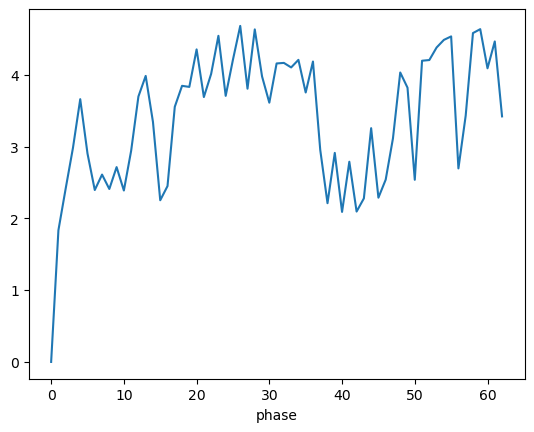

In [553]:
foo = phase_results.groupby('phase')
foo.min('sum_diff')['sum_diff'].plot()

<Axes: xlabel='phase'>

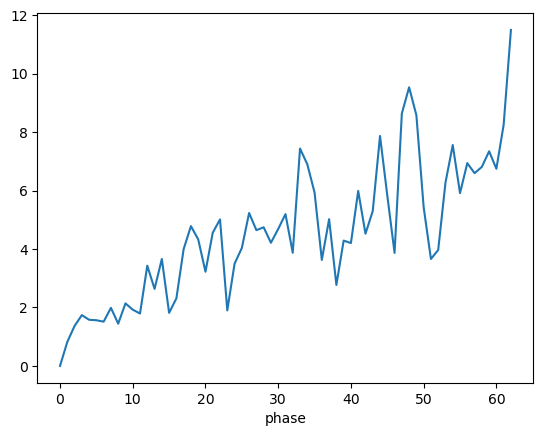

In [554]:
foo = phase_results.groupby('phase')
foo.min('geom_feature_dist')['geom_feature_dist'].plot()

<Axes: xlabel='phase'>

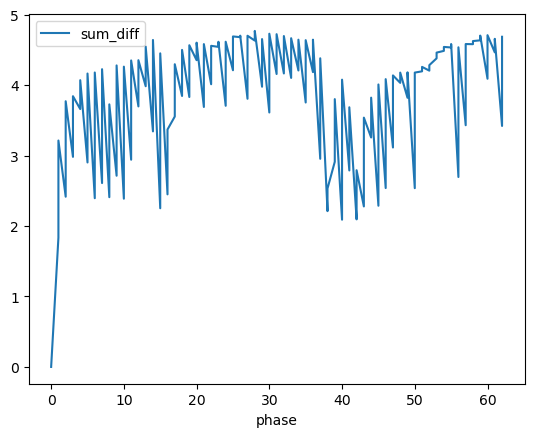

In [555]:
phase_results.plot(x='phase', y = 'sum_diff')

<Axes: xlabel='phase'>

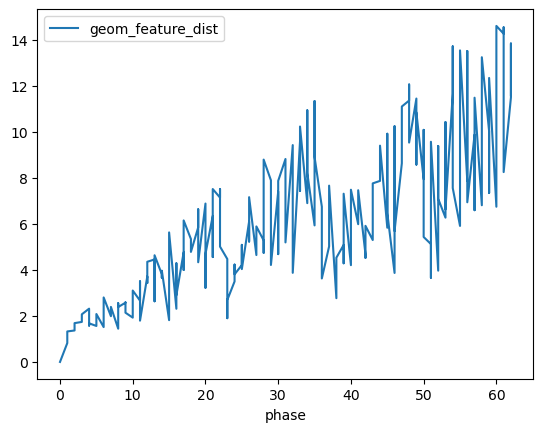

In [556]:
phase_results.plot(x='phase', y = 'geom_feature_dist')

In [557]:
len(cluster_gdf)

213

In [558]:
cluster_idxs = list(phase_results.grid_idx)
cluster_gdf = gdf_normalized[gdf_normalized['grid_idx'].isin(cluster_idxs)]
cluster_gdf.explore()

In [559]:
cluster_gdf.to_csv('../kepler/scbd_clusters.csv', index = False)

In [560]:
def within_boundary_distance(gdf, sim_cal_cols) -> float:
    pairwise_distances = []
    for row1, row2 in combinations(gdf.iterrows(), 2):
        distance = sum(abs(row1[1][col] - row2[1][col]) for col in SIM_CAL_COLS)
        pairwise_distances.append(distance)
    # average_distance = sum(pairwise_distances) / len(pairwise_distances)
    average_distance = sum(pairwise_distances) / len(pairwise_distances)
    # boundary_similarity = math.exp(-(average_distance/100))
    penalty = math.sqrt(len(gdf))
    # penalty = 1 / math.sqrt(len(pairwise_distances))
    return average_distance * penalty

def within_boundary_similarity(dist, n_cluster) -> float:
    return math.exp(-dist/100)

In [561]:
phase_results.groupby('phase').mean('diffs')['diffs'].plot()

KeyError: 'diffs'